# 区域生长算法原理

## 1. 基于区域生长算法的图像分割原理

数字图像分割算法一般是基于灰度值的两个基本特性之一：不连续性和相似性。前一种性质的应用途径是基于图像灰度的不连续变化分割图像，比如图像的边缘。第二种性质的主要应用途径是依据实现指定的准则将图像分割为相似的区域。区域生长算法就是基于图像的第二种性质，即图像灰度值的相似性。

### 1.1 基本公式

令R表示整幅图像区域，那么分割可以看成将区域R划分为n个子区域R1,,R2,......Rn的过程，并需要满足以下条件：
a: U(Ri) = R;
b: Ri是一个连通区域，i=1,2,3,......n;
c: Ri ∩ Rj = 空集，对于任何的i,j；都有i≠j;
d: P(Ri) = Ture, 对i=1,2,......n;
e: R(Pi U Rj) = False, i≠j；
正如“区域生长”的名字所暗示的：区域生长是根据一种事先定义的准则将像素或者子区域聚合成更大区域的过程，并且要充分保证分割后的区域满足a~e的条件。

### 1.2 区域生长算法设计思路

区域生长算法的设计主要由以下三点：生长种子点的确定，区域生长的条件，区域生长停止的条件。种子点的个数根据具体的问题可以选择一个或者多个，并且根据具体的问题不同可以采用完全自动确定或者人机交互确定。

区域生长的条件实际上就是根据像素灰度间的连续性而定义的一些相似性准则，而区域生长停止的条件定义了一个终止规则，基本上，在没有像素满足加入某个区域的条件的时候，区域生长就会停止。在算法里面，定义一个变量，最大像素灰度值距离reg_maxdist.当待加入像素点的灰度值和已经分割好的区域所有像素点的平均灰度值的差的绝对值小于或等于reg_maxdist时，该像素点加入到已经分割到的区域。相反，则区域生长算法停止。
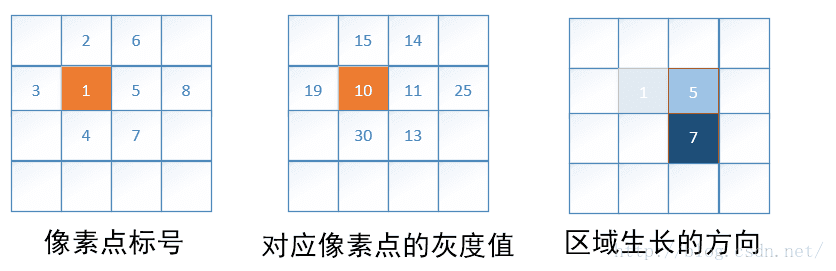

在种子店1的4邻域连通像素中，即2、3、4、5点，像素点5的灰度值与种子点的灰度值最接近，所以像素点5被加入到分割区域中，并且像素点5会作为新的种子点执行后面的过程。在第二次循环过程中，由于待分析图像中，即2、3、4、6、7、8，像素7的灰度值和已经分割的区域（由1和5组成）的灰度均值10.5最接近，所以像素点7被加入到分割区域中。最后一幅图，示意了区域生长的方向（由浅入深）。
从上面的分析中，我们可以看出，在区域生长过程中，需要知道待分析像素点的编号（通过像素点的x和y坐标值来表示），同时还要知道这些待分析点的像素的灰度值。

### 1.3 区域生长算法伪代码
```
begin

初始化变量 pixdist = 0；

交互式选择一个种子点，并且初始化区域的灰度均值变量reg_mean为该种子点的灰度值。

while (pixdist < reg_maxdist)

将当前种子点的四邻域像素点加入到链表neg_list中；

分别计算neg_list中所有元素的灰度值和reg_mean差的绝对值，并且得到最小值的元素i(x,y).令pixdist = abs(neg_list(i,3)-reg_mean)；

更新 reg_mean = (reg_mean*reg_size + neg_list(i,3))/(reg_size + 1);（注：reg_size表示分割好区域内像素点的数量）

将旧的种子点标记为已经分割好的区域像素点

将i(x,y)当做新的种子点，并将新的种子点i(x,y)从链表neg_list中移除

end

end

```

In [ ]:
'''
% Segment based on area, Region Growing;
clear  all; close all; clc
[fileName,pathName] = uigetfile('*.*','Please select an image');%文件筐，选择文件
if(fileName)
    fileName = strcat(pathName,fileName);
    fileName = lower(fileName);%一致的小写字母形式
else 
    J = 0;%记录区域生长所分割得到的区域
    msgbox('Please select an image');
    return; %退出程序
end
 
I = imread(fileName);
if( ~( size(I,3)-3 ))
    I = rgb2gray(I);%转化为单通道灰度图
end
I = im2double(I); %图像灰度值归一化到[0,1]之间
Ireshape = imresize(I,[600,800]);
I = Ireshape(51:475,200:699);
gausFilter = fspecial('gaussian',[5 5],0.5);
I = imfilter(I,gausFilter,'replicate');
 
%种子点的交互式选择
if( exist('x','var') == 0 && exist('y','var') == 0)
    subplot(2,2,1),imshow(I,[]);
    hold on;
    [y,x] = getpts;%鼠标取点  回车确定
    x = round(x(1));%选择种子点
    y = round(y(1));
end
 
if( nargin == 0)
    reg_maxdist = 0.1;
    %nargin是matlab代码编写中常用的一个技巧，主要用于计算当前主函数的输入参数个
    %数，一般可以根据nargin的返回值来确定主函数输入参数的缺省值。在实现中，如果
    %用户输入的参数个数为零，那么默认为0.2
end
J = zeros(size(I)); % 主函数的返回值，记录区域生长所得到的区域
Isizes = size(I);
reg_mean = I(x,y);%表示分割好的区域内的平均值，初始化为种子点的灰度值
reg_size = 1;%分割的到的区域，初始化只有种子点一个
neg_free = 10000; %动态分配内存的时候每次申请的连续空间大小
neg_list = zeros(neg_free,3);
%定义邻域列表，并且预先分配用于储存待分析的像素点的坐标值和灰度值的空间，加速
%如果图像比较大，需要结合neg_free来实现matlab内存的动态分配
neg_pos = 0;%用于记录neg_list中的待分析的像素点的个数
pixdist = 0;
%记录最新像素点增加到分割区域后的距离测度
%下一次待分析的四个邻域像素点和当前种子点的距离
%如果当前坐标为（x,y）那么通过neigb我们可以得到其四个邻域像素的位置
neigb = [ -1 0;
          1  0;
          0 -1;
          0  1];
 %开始进行区域生长，当所有待分析的邻域像素点和已经分割好的区域像素点的灰度值距离
 %大于reg_maxdis,区域生长结束
 
 while (pixdist < 0.06 && reg_size < numel(I))
     %增加新的邻域像素到neg_list中
     for j=1:4
         xn = x + neigb(j,1);
         yn = y + neigb(j,2);
         %检查邻域像素是否超过了图像的边界
         ins = (xn>=1)&&(yn>=1)&&(xn<=Isizes(1))&&(yn<=Isizes(1));
         %如果邻域像素在图像内部，并且尚未分割好；那么将它添加到邻域列表中
         if( ins && J(xn,yn)==0)
             neg_pos = neg_pos+1;
             neg_list(neg_pos,:) =[ xn, yn, I(xn,yn)];%存储对应点的灰度值
             J(xn,yn) = 1;%标注该邻域像素点已经被访问过 并不意味着，他在分割区域内
         end
     end
    %如果分配的内存空问不够，申请新的内存空间
    if (neg_pos+10>neg_free)
        neg_free = neg_free + 100000;
        neg_list((neg_pos +1):neg_free,:) = 0;
    end
    %从所有待分析的像素点中选择一个像素点，该点的灰度值和已经分割好区域灰度均值的
    %差的绝对值时所待分析像素中最小的
    dist = abs(neg_list(1:neg_pos,3)-reg_mean);
    [pixdist,index] = min(dist);
    %计算区域的新的均值
    reg_mean = (reg_mean * reg_size +neg_list(index,3))/(reg_size + 1);
    reg_size = reg_size + 1;
    %将旧的种子点标记为已经分割好的区域像素点
    J(x,y)=2;%标志该像素点已经是分割好的像素点
    x = neg_list(index,1);
    y = neg_list(index,2);
%     pause(0.0005);%动态绘制
%     if(J(x,y)==2)
%     plot(x,y,'r.');
%     end
    %将新的种子点从待分析的邻域像素列表中移除
    neg_list(index,:) = neg_list(neg_pos,:);
    neg_pos = neg_pos -1;
 end
 
 J = (J==2);%我们之前将分割好的像素点标记为2
 hold off;
 subplot(2,2,2),imshow(J);
 J = bwmorph(J,'dilate');%补充空洞
 subplot(2,2,3),imshow(J);
 subplot(2,2,4),imshow(I+J);
'''

参考:

[1]. https://blog.csdn.net/shenziheng1/article/details/50878911